# DeepFool Adversarial Attack


DeepFool is an untargeted adversarial attack algorithm that computes the minimal perturbation needed to change the classification of an input image.

The goal is to find the smallest possible change to the input image that fools the model — i.e., causes it to misclassify.

DeepFool assumes the classifier behaves approximately like a linear function around the current input. This makes it easier to estimate where the decision boundary lies. At each step, the algorithm computes the gradient of the output logits (before softmax) with respect to the input.It then estimates how far the current input is from the nearest class boundary, using a linear approximation. At each step it only makes a minimal move, ensuring the overall perturbation stays small.


The final perturbed image looks nearly identical to the original. The total perturbation is barely noticeable but highly effective.


DeepFool demonstrates that neural networks are vulnerable to small, human-imperceptible changes in input.

Compared to other attacks in the repository, this one performs the better, as its pertubations are the most indistinguishable for human eye


In this notebook, we demonstrate how DeepFool works using a pretrained ResNet34 and analyze the saliency and perturbation effects.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.models as models
from PIL import Image
import os
import requests
from io import BytesIO
import json
import urllib.request
import copy
from torch.autograd import Variable
import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(69)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defining the attack function

In [4]:

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=50):

    is_cuda = torch.cuda.is_available()

    if is_cuda:
        print("Using GPU")
        image = image.cuda()
        net = net.cuda()
    else:
        print("Using CPU")


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):

            if x.grad is not None:
                x.grad.zero_()

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [5]:
model = models.resnet18(pretrained=True)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Load ImageNet labels
labels = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
filename = "imagenet_classes.txt"
urllib.request.urlretrieve(labels, filename)

with open(filename, "r") as f:
    classes = [line.strip() for line in f.readlines()]


In [7]:
# Load and preprocess image
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Laubfrosch_cropped.jpg/1200px-Laubfrosch_cropped.jpg'
response = requests.get(url)
im_orig = Image.open(BytesIO(response.content)).convert('RGB')


In [8]:
mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]

im = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std = std)])(im_orig)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
im = transform(im_orig)

In [10]:
# DeepFool attack
r, loop_i, label_orig, label_pert, pert_image = deepfool(im, model)


Using CPU


In [11]:
# Convert class indices to label strings
str_label_orig = f"{label_orig}: {classes[int(label_orig)]}"
str_label_pert = f"{label_pert}: {classes[int(label_pert)]}"


In [12]:
# Define clip and denormalization transform
def clip_tensor(A, minv, maxv):
    A = torch.max(A, minv * torch.ones(A.shape))
    A = torch.min(A, maxv * torch.ones(A.shape))
    return A

clip = lambda x: clip_tensor(x, 0, 255)

tf = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    transforms.Lambda(clip),
    transforms.ToPILImage(),
    transforms.CenterCrop(224)
])


Original label = 31: tree frog
Perturbed label = 40: American chameleon


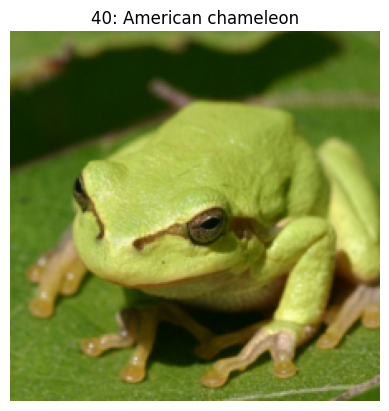

In [13]:
print("Original label =", str_label_orig)
print("Perturbed label =", str_label_pert)

# Show perturbed image
plt.figure()
plt.imshow(tf(pert_image.cpu()[0]))
plt.title(str_label_pert)
plt.axis('off')
plt.show()

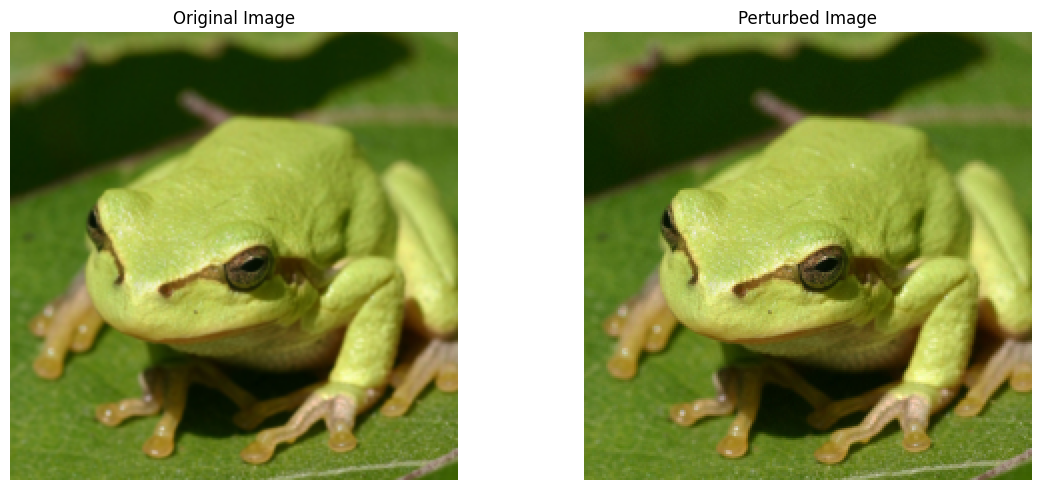

In [14]:
# Denormalization transform
inv_tf = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    transforms.Lambda(clip),
    transforms.ToPILImage()
])

# Visualize original and perturbed images
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(inv_tf(im.cpu()))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(inv_tf(pert_image.cpu()[0]))
plt.title("Perturbed Image")
plt.axis('off')

plt.tight_layout()
plt.show()


## Analysing pertubations

#### Raw Perturbation (RGB Difference)

This visualization shows the **raw pixel-wise differences** (ΔRGB) between the original and adversarial images.

Unlike the heatmap, this view gives a direct look at what was added to the image — essentially the "noise pattern" crafted by the attack. It's especially useful for understanding the direction and structure of adversarial noise in each region.


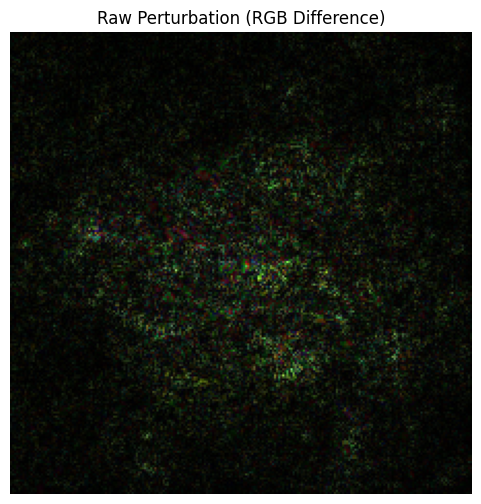

In [15]:
# Convert difference to grayscale magnitude
diff = (pert_image - im.unsqueeze(0)).squeeze().cpu().numpy()
diff = np.transpose(diff, (1, 2, 0))
diff = np.abs(diff)
diff = diff / diff.max()


plt.figure(figsize=(6, 6))
plt.imshow(diff)
plt.title("Raw Perturbation (RGB Difference)")
plt.axis('off')
plt.show()


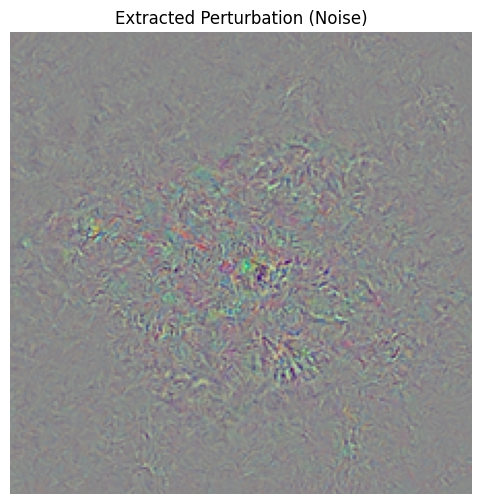

In [16]:
noise = (pert_image - im.unsqueeze(0)).squeeze().detach().cpu()

noise_np = noise.numpy()
noise_np = np.transpose(noise_np, (1, 2, 0))  # CHW → HWC
noise_min, noise_max = noise_np.min(), noise_np.max()
noise_img = (noise_np - noise_min) / (noise_max - noise_min)

plt.figure(figsize=(6, 6))
plt.imshow(noise_img)
plt.title("Extracted Perturbation (Noise)")
plt.axis('off')
plt.show()


## Saliency Maps
Saliency maps show which parts of the image most influence the model's decision.
The Gradient Magnitude Map highlights the areas of the image that the model relied on most for its prediction.

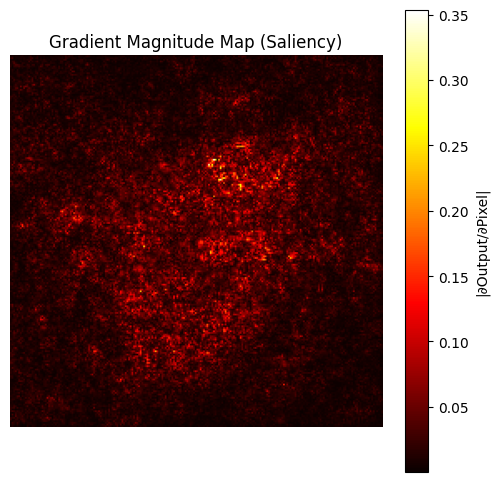

In [17]:
im_var = im.clone().detach().unsqueeze(0)
im_var.requires_grad = True

# Forward pass
output = model(im_var)
pred_label = output.argmax(dim=1).item()
score = output[0, pred_label]

# Backward pass to get gradient w.r.t input
score.backward()

# Gradient magnitude (L∞ across channels)
grad = im_var.grad.data.squeeze().cpu()
saliency, _ = torch.max(grad.abs(), dim=0)

# Plot gradient magnitude map
plt.figure(figsize=(6, 6))
plt.imshow(saliency, cmap='hot')
plt.title("Gradient Magnitude Map (Saliency)")
plt.axis('off')
plt.colorbar(label='|∂Output/∂Pixel|')
plt.show()
